# Estimating the true case counts per country and overall mortality rate for COVID-19

### Country-level covariates
We've listed out few of the factors that may account for observed differences in mortality rates:

In [3]:
# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from source import data, model

In [4]:
# Load the data (see source/data.py):
df = data.get_data_case_count_model()

#### First we do some exploratory data analysis, plotting the country-wise covariates against each other and the country-wise COVID-19 mortality rates.

In [5]:
print('Overall observed mortality rate: %.2f%%' % (100.0 * df['deaths'].sum() / df['cases'].sum()))

Overall observed mortality rate: 4.09%


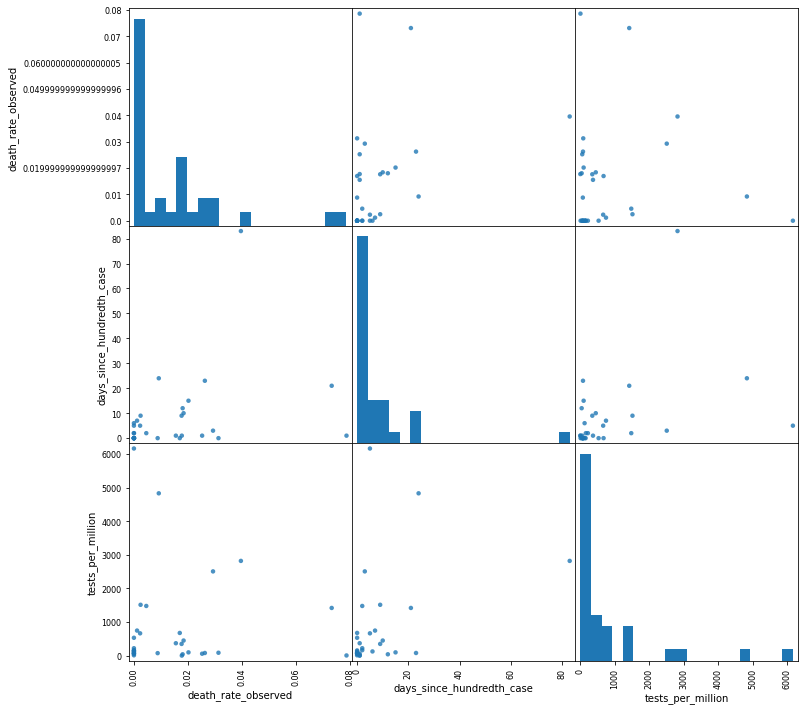

In [6]:
pairs = pd.plotting.scatter_matrix(df[df.columns[2::]], figsize=(12, 12),
                        hist_kwds={'bins': 20}, s=80, alpha=.8)

# Model

The approach here is to fit a hierarchical Bayes Binomial model on the case & death counts, while also controlling for the country-level covariates using a GLM with logit link function for the country-level mortality rates.

All model code (using pymc3) can be found in source/model.py.

### Mathematical description of model
For those desiring more detailed information about the model, please refer to the text below:


In [16]:
# Initialize the model:
import importlib
importlib.reload(model)
mod = model.case_count_model(df)

In [17]:
# Run MCMC sampler
with mod:
    trace = pm.sample(200, tune=500,
                      chains=2, cores=3)


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 3 jobs)
NUTS: [c_star_log, sigma, beta, mu_0]
Sampling 2 chains, 0 divergences: 100%|██████████| 1400/1400 [04:25<00:00,  5.28draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
# Visualize the trace of the MCMC sampler to assess convergence
pm.traceplot(trace)

In [ ]:
# Posterior plot for mu0
pm.plot_posterior(trace, var_names=['mu_0'], figsize=(14, 6), textsize=18,
                  credible_interval=0.95, bw=1.0, lw=3, kind='kde')
plt.xlim(0.0, 0.05)

In [ ]:
n_samp = len(trace['mu_0'])
mu0_summary = pm.summary(trace).loc['mu_0']
print("COVID-19 Global Mortality Rate.")
print("Posterior mean: %0.3f" % trace['mu_0'].mean())
print("Posterior median: %0.3f" % np.median(trace['mu_0']))
lower = np.sort(trace['mu_0'])[int(n_samp*0.025)]
upper = np.sort(trace['mu_0'])[int(n_samp*0.975)]
print("95%% (2.5%% - 97.5%%) posterior interval: (%0.3f, %0.3f)" % (lower, upper))
print("95%% (HPD) posterior interval: (%0.3f, %0.3f)" % (mu0_summary['hpd_3%'], mu0_summary['hpd_97%']))

In [ ]:
# Posterior summary for the alpha and beta parameters:
beta_summary = pm.summary(trace).head(5)
# beta_summary.index = ['days_since_first_case', 'cpi', 'healthcare_oop', 'hospital_beds', 'hci', 'percent_over65', 'percent_rural']
# beta_summary.reset_index(drop=False, inplace=True)
beta_summary

In [ ]:
import matplotlib.pyplot as plt

err_vals = ((beta_summary['hpd_3%'] - beta_summary['mean']).values,
            (beta_summary['hpd_97%'] - beta_summary['mean']).values)
ax = beta_summary.plot(x='index', y='mean', kind='bar', figsize=(10, 6),
                 title='Posterior Distribution of Beta Parameters',
                 yerr=err_vals, color='lightgrey',
                 legend=False, grid=True,
                 capsize=5)
beta_summary.plot(x='index', y='mean', color='k', marker='o', linestyle='None',
                  ax=ax, grid=True, legend=False, xlim=plt.gca().get_xlim())

### Interpretation of beta parameters:

1. days_since_first_case - positive (very statistically significant).  As time since outbreak increases, expected mortality rate **increases**, as expected.
2. cpi - negative (statistically significant).  As government transparency increases, expected mortality rate **decreases**.  This is also as expected by our original hypothesis -- corrupt governments will under-report cases (but have a harder time under-reporting deaths), hence inflating the mortality rate.
3. healthcare OOP spending - no significant trend.
4. HCI - no significant trend.
5. percent over 65 - positive (statistically significant).  As population age increases, the mortality rate also **increases**, as expected.
6. percent rural - slightly negative (barely significant).  The more people that live in rural areas, the reported mortality rate **decreases**.  Sensible, given the reporting difficulties for rural populations.

These all seem very sensible, and help validate our numerical results.

## Conclusion

A couple of take-home points from the analysis.

1. The "best guess" estimate of mortality rate, once correcting for country-level factors, is only 0.5% -- as opposed to a 3.5% global mortality rate observed in the data.  The take-home here is that this is **driven by suppression in the reporting of cases**.  That is, **there are a lot more COVID-19 cases right now than are being reported!**  Likely a factor of ~7 more.
2. Given the current data, our bounds on the true mortality rate are (0.1%, 2%), meaning that we can not yet rule out mortality rates of up to 2%.
3. The contry-level factors that most impact the reported mortality rate are:
    * days since outbreak (more mature outbreak --> higher mortality)
    * gov't transparency index (more transparent --> lower reported mortality)
    * % of population over 65 (higher aged population --> higher mortality)
    * % of population rural (more rural --> lower reported mortality)
    
We will continue to re-run the analysis periodically as more data come in, to continually improve the precsion of the estimated mortality rate.  Further, as case data that is broken down by age range is made available, we can perform a more detailed estimate of mortality by age range.